# Linear regression example

Data was taken from: https://www.kaggle.com/mirichoi0218/insurance

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check bmi distribution

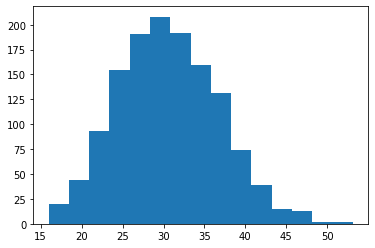

In [3]:
dataNp = data.to_numpy()
bmi = dataNp[:,2]
bmi = bmi.astype('float64')

plt.hist(bmi, bins=15)
plt.show()

### Check charges distribution

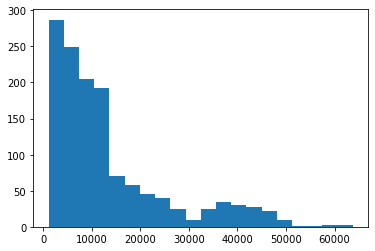

In [4]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
children = dataNp[:, 3]
charges = dataNp[:, 6]
charges = charges.astype('float64')


plt.hist(charges, bins=20)
plt.show()

### Checking relationship between age and charges

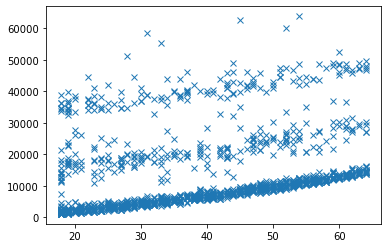

In [5]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

### Train the model with pytorch

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [73]:
#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
norm = np.linalg.norm(X_train)
X_train =  X_train / norm
norm = np.linalg.norm(X_test)
X_test =  X_test / norm

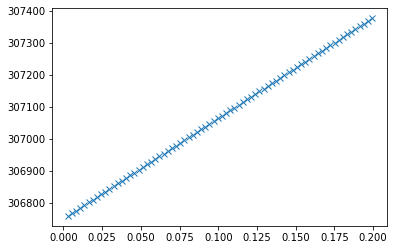

In [77]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

beta0 = linr.intercept_
beta1 = linr.coef_[0]

xplot = np.arange(1, 75)
norm = np.linalg.norm(xplot)
xplot =  xplot / norm
yplot = xplot * beta0 + beta1

plt.plot(xplot, yplot, 'x');

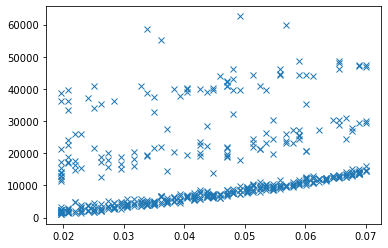

In [75]:
#yplot = X_test * beta0 + beta1

plt.plot(X_test, y_test, 'x');
#plt.plot(X_test, yplot);

In [90]:
n_epochs = 90
batch_size_train = testDataSize
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.5
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))
#tensor_test_y = tensor_test_y.type(torch.LongTensor)
# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))
#tensor_test_y = tensor_test_y.type(torch.LongTensor)
# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [91]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [92]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [124]:
def train(epoch):
  #Configure network for training
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    #here data contains a 64 * 1 * 28 * 28 tensor, 64 is batch size
    output = network(data)
    
    #Use negative log likelihood loss.
    loss = LossFunction(output, target)
    
    #with this gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [125]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
        
      #acumulate the loss
      test_loss += LossFunction(output, target).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [126]:

#test
#n_epochs = 1

#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")


Test set: Avg. loss: 332355.3092, Accuracy: 0/469 (0%)

Train Epoch: 1 [0/869 (0%)]	Loss: 135646976.000000

Test set: Avg. loss: 332345.6205, Accuracy: 0/469 (0%)

Train Epoch: 2 [0/869 (0%)]	Loss: 141187920.000000

Test set: Avg. loss: 332316.8955, Accuracy: 0/469 (0%)

Train Epoch: 3 [0/869 (0%)]	Loss: 138878608.000000

Test set: Avg. loss: 332340.5032, Accuracy: 0/469 (0%)

Train Epoch: 4 [0/869 (0%)]	Loss: 138154320.000000

Test set: Avg. loss: 332340.0597, Accuracy: 0/469 (0%)

Train Epoch: 5 [0/869 (0%)]	Loss: 127879408.000000

Test set: Avg. loss: 332350.3966, Accuracy: 0/469 (0%)

Train Epoch: 6 [0/869 (0%)]	Loss: 142703744.000000

Test set: Avg. loss: 332321.5011, Accuracy: 0/469 (0%)

Train Epoch: 7 [0/869 (0%)]	Loss: 125068904.000000

Test set: Avg. loss: 332337.1258, Accuracy: 0/469 (0%)

Train Epoch: 8 [0/869 (0%)]	Loss: 147403568.000000

Test set: Avg. loss: 332314.7122, Accuracy: 0/469 (0%)

Train Epoch: 9 [0/869 (0%)]	Loss: 146014176.000000

Test set: Avg. loss: 332319


Test set: Avg. loss: 332277.0832, Accuracy: 0/469 (0%)

Train Epoch: 80 [0/869 (0%)]	Loss: 153376448.000000

Test set: Avg. loss: 332256.1023, Accuracy: 0/469 (0%)

Train Epoch: 81 [0/869 (0%)]	Loss: 141461584.000000

Test set: Avg. loss: 332272.8188, Accuracy: 0/469 (0%)

Train Epoch: 82 [0/869 (0%)]	Loss: 151614192.000000

Test set: Avg. loss: 332277.4925, Accuracy: 0/469 (0%)

Train Epoch: 83 [0/869 (0%)]	Loss: 138415728.000000

Test set: Avg. loss: 332278.3795, Accuracy: 0/469 (0%)

Train Epoch: 84 [0/869 (0%)]	Loss: 148887232.000000

Test set: Avg. loss: 332268.9638, Accuracy: 0/469 (0%)

Train Epoch: 85 [0/869 (0%)]	Loss: 142293840.000000

Test set: Avg. loss: 332275.4797, Accuracy: 0/469 (0%)

Train Epoch: 86 [0/869 (0%)]	Loss: 129193408.000000

Test set: Avg. loss: 332298.3028, Accuracy: 0/469 (0%)

Train Epoch: 87 [0/869 (0%)]	Loss: 141270096.000000

Test set: Avg. loss: 332282.9851, Accuracy: 0/469 (0%)

Train Epoch: 88 [0/869 (0%)]	Loss: 137772160.000000

Test set: Avg. los

In [127]:
#network.linear.weight[0]
#type(network.linear)

xplot = np.arange(1, 75)
norm = np.linalg.norm(xplot)
xplot =  xplot / norm

network.eval()
with torch.no_grad():
    yplot = network(test_data)


AttributeError: 'TensorDataset' object has no attribute 'dim'

# References

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

Loss is high, but this might be because output values are high too.
Options to do
-Normalize outputs and train model again
-Evaluate model output and check what is the result against real data